# High Performance Machine Learning lab
Simple TensorFlow 2.0 GAN for Fashion-MNIST image generation.

## Author: Paweł Rościszewski and Robert Benke
  based on the [TensorFlow 2.0 in Action blogpost](https://blog.paperspace.com/tensorflow-2-0-in-practice/)

In [1]:
import tensorflow as tf
import numpy as np
import time 
import tensorflow.keras.layers as layers
from tensorflow.python.framework.ops import EagerTensor
from random import random
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
%matplotlib inline

In [2]:
BATCH_SIZE = 32
NOISE_DIM = 32

#### Function for reshaping images into the multiple resolutions we will use

In [3]:
def image_reshape(x):
    return [
        tf.image.resize(x, (8, 8)),
        tf.image.resize(x, (16, 16)),
        x
    ]

#### Fashion-MNIST is a drop in replacement for MNIST that is harder to solve 

In [4]:
def load_dataset(batch_size):
    (train_images, _), (_, _) = tf.keras.datasets.cifar10.load_data()
    train_images = train_images.reshape([-1, 32, 32, 3]).astype('float32')
    train_images = train_images/127.5  - 1
    dataset = tf.data.Dataset.from_tensor_slices(train_images)
    dataset = dataset.map(image_reshape)
    dataset = dataset.cache()
    dataset = dataset.shuffle(len(train_images))
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(1)
    steps_per_epoch = int(len(train_images) / batch_size)
    return dataset, steps_per_epoch

#### Visualizing the images using matplotlib

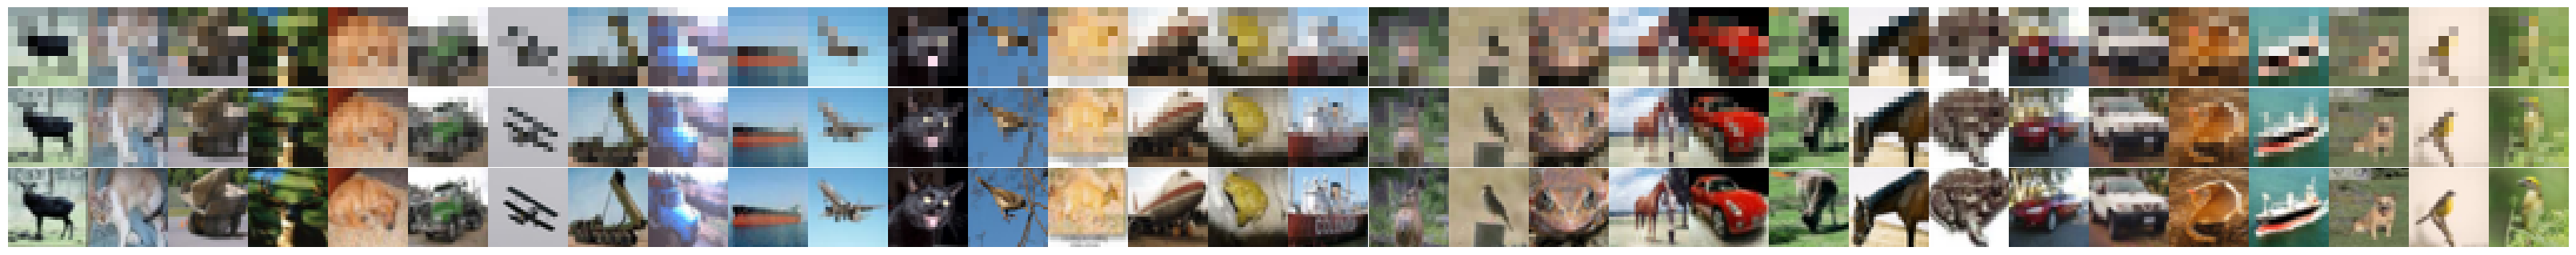

In [5]:
def plot_sample(sample):
    num_samples = min(32, len(sample[0]))

    grid = gridspec.GridSpec(3, num_samples)
    grid.update(left=0, bottom=0, top=1, right=1, wspace=0.01, hspace=0.01)
    fig = plt.figure(figsize=[num_samples, 3])
    for x in range(3):
        images = sample[x]
        if type(sample[x]) == EagerTensor:
            images = images.numpy() #this converts the tensor to a numpy array
        images = np.squeeze(images)
        for y in range(num_samples):
            ax = fig.add_subplot(grid[x, y])
            ax.set_axis_off()
            ax.imshow((images[y] + 1.0)/2)
    plt.show()
    
dataset, steps_per_epoch = load_dataset(BATCH_SIZE)
for sample in dataset:
    plot_sample(sample)
    break

In [6]:
class GraphModel(tf.keras.Model):
    
    @tf.function
    def __call__(self, *args, **kwargs):
        return super().__call__(*args, **kwargs)

def generator_model():
    outputs = []

    z_in = tf.keras.Input(shape=(NOISE_DIM,))
    x = layers.Dense(8*8*256)(z_in)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((8, 8, 256))(x)

    for i in range(3):
        if i == 0:
            x = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1),
                padding='same')(x)
            x = layers.BatchNormalization()(x)
            x = layers.LeakyReLU()(x)
        else:
            x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2),
                padding='same')(x)
            x = layers.BatchNormalization()(x)
            x = layers.LeakyReLU()(x)

        x = layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        print(i)
        outputs.append(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1),
            padding='same', activation='tanh')(x))
        print(outputs)

    model = GraphModel(inputs=z_in, outputs=outputs)
    return model

def discriminator_model():
    # we have multiple inputs to make a real/fake decision from
    inputs = [
        tf.keras.Input(shape=(32, 32, 3)),
        tf.keras.Input(shape=(16, 16, 3)),
        tf.keras.Input(shape=(8, 8, 3))
    ]

    x = None
    print(inputs)
    for image_in in inputs:
        print(image_in)
        if x is None:
            # for the first input we don't have features to append to
            x = layers.Conv2D(64, (5, 5), strides=(2, 2),
                padding='same')(image_in)
            print('conv')
            print(x)
            x = layers.LeakyReLU()(x)
            print('relu')
            print(x)
            x = layers.Dropout(0.3)(x)
        else:
            # every additional input gets its own conv layer then appended
            y = layers.Conv2D(64, (5, 5), strides=(2, 2),
                padding='same')(image_in)
            y = layers.LeakyReLU()(y)
            y = layers.Dropout(0.3)(y)
            print('before concat')
            print(x)
            print(y)
            x = layers.concatenate([x, y])

        x = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
        x = layers.LeakyReLU()(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(x)
        x = layers.LeakyReLU()(x)
        x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    out = layers.Dense(3)(x)
    inputs = inputs[::-1] # reorder the list to be smallest resolution first
    model = GraphModel(inputs=inputs, outputs=out)
    return model

# prediction of 0 = fake, 1 = real
def discriminator_loss(real_output, fake_output): 
    real_loss = tf.nn.sigmoid_cross_entropy_with_logits(
        tf.ones_like(real_output), real_output)
    fake_loss = tf.nn.sigmoid_cross_entropy_with_logits(
        tf.zeros_like(fake_output), fake_output)
    return tf.nn.compute_average_loss(real_loss + fake_loss)

def generator_loss(fake_output): 
    loss = tf.nn.sigmoid_cross_entropy_with_logits(
        tf.ones_like(fake_output), fake_output)
    return tf.nn.compute_average_loss(loss)


In [7]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return generated_images


def train(dataset, epochs):
    for epoch in range(epochs): 
        for idx, image_batch in enumerate(dataset):
            if idx>=5:
                break
            begin = time.time()
            gi = train_step(image_batch)
            end =  time.time()
            
            print("print: Iter time: ", end - begin)
            tf.print("tf.print: Iter time: ", end - begin)

In [8]:
dataset, steps_per_epoch = load_dataset(BATCH_SIZE)


generator = generator_model()
discriminator = discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

train(dataset, 1)

0
[<KerasTensor: shape=(None, 8, 8, 3) dtype=float32 (created by layer 'conv2d_transpose_1')>]
1
[<KerasTensor: shape=(None, 8, 8, 3) dtype=float32 (created by layer 'conv2d_transpose_1')>, <KerasTensor: shape=(None, 16, 16, 3) dtype=float32 (created by layer 'conv2d_transpose_3')>]
2
[<KerasTensor: shape=(None, 8, 8, 3) dtype=float32 (created by layer 'conv2d_transpose_1')>, <KerasTensor: shape=(None, 16, 16, 3) dtype=float32 (created by layer 'conv2d_transpose_3')>, <KerasTensor: shape=(None, 32, 32, 3) dtype=float32 (created by layer 'conv2d_transpose_5')>]
[<KerasTensor: shape=(None, 32, 32, 3) dtype=float32 (created by layer 'input_2')>, <KerasTensor: shape=(None, 16, 16, 3) dtype=float32 (created by layer 'input_3')>, <KerasTensor: shape=(None, 8, 8, 3) dtype=float32 (created by layer 'input_4')>]
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
conv
KerasTensor(type_spec=TensorS